In [2]:
import pandas as pd
import pubchempy as pcp

water_miscibility_df = pd.read_csv("water_miscibility_table.csv")
aqueous_solubility_df = pd.read_csv("Aqueous_Solubility.csv")[["Solubility Prediction", "Molecule_InChIKey"]]
aqueous_solubility_df.rename(columns={"Molecule_InChIKey": "Solvent_InChIKey"}, inplace=True)


def fun_to_apply(row):
    solvent_name = row["Solvent"]
    compounds = pcp.get_compounds(solvent_name, 'name')
    return compounds[0].inchikey

water_miscibility_df["Solvent_InChIKey"] = water_miscibility_df.apply(fun_to_apply, axis=1)

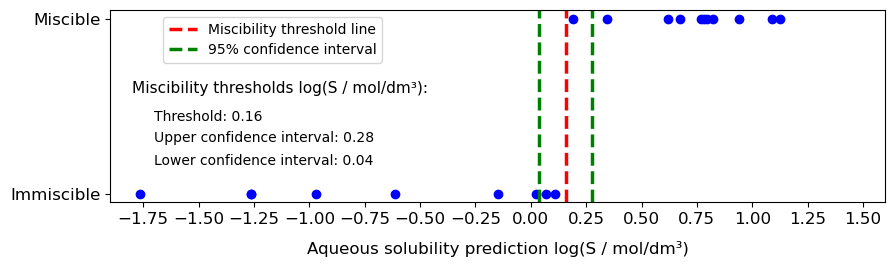

In [3]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np

final_dataframe = pd.merge(water_miscibility_df, aqueous_solubility_df, how='inner', on='Solvent_InChIKey')
final_dataframe['Miscible with Water'] = final_dataframe['Miscible with Water'].map({True: 1, False: 0})

X = final_dataframe[['Solubility Prediction']]
y = final_dataframe['Miscible with Water']

model = SVC(kernel='linear', probability=True)
model.fit(X, y)

threshold_x = -model.intercept_[0] / model.coef_[0][0]
predictions = model.predict_proba(X)[:, 1]

std_error = np.sqrt(predictions * (1 - predictions) / len(X))
confidence_interval = 1.96 * std_error 

lower_bound = predictions - confidence_interval
upper_bound = predictions + confidence_interval

threshold_lower = threshold_x - confidence_interval.mean()  
threshold_upper = threshold_x + confidence_interval.mean()

plt.figure(figsize=(10, 2.5))
plt.scatter(final_dataframe['Solubility Prediction'], final_dataframe['Miscible with Water'], color='blue')
plt.axvline(threshold_x, color='red', linestyle='--', linewidth=2.5, label=f'Miscibility threshold line')
plt.axvline(threshold_upper, color='green', linestyle='--', linewidth=2.5, label=f'95% confidence interval')
plt.axvline(threshold_lower, color='green', linestyle='--', linewidth=2.5)

plt.xlim(left=-1.9) 
plt.xlim(right=1.6)
plt.locator_params(axis='x', nbins=15) 
plt.tick_params(axis='both', which='major', labelsize=12)  
plt.xlabel('Aqueous solubility prediction log(S / mol/dm³)', fontsize=12, labelpad=10)
plt.text(-1.8, 0.60, f'Miscibility thresholds log(S / mol/dm³):', fontsize=11, verticalalignment='center', horizontalalignment='left')
plt.text(-1.7, 0.44, f'Threshold: {threshold_x:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.text(-1.7, 0.32, f'Upper confidence interval: {threshold_upper:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.text(-1.7, 0.19, f'Lower confidence interval: {threshold_lower:.2f}', fontsize=10, verticalalignment='center', horizontalalignment='left')
plt.yticks([0, 1], ['Immiscible', 'Miscible'])
plt.legend(bbox_to_anchor=(0.36, 1.0))
plt.savefig("Miscibility Threshold.png")